In [2]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

# Gyro. model plot on data

dereddening using dustmap: dustmaps.bayestar

BV to temperature relation from: https://arxiv.org/pdf/astro-ph/9904299.pdf assuming [Fe/H]=0 and ignore the logg term. 

Model data from: https://arxiv.org/pdf/1908.00345.pdf

Gaia color to temperature from Ruth's function bprp_to_teff()

In [45]:
VD_single=np.load('VD_single.npy')
Teff_model=np.load('Teff_model.npy')
Prot=np.load('Prot_model.npy')
VD_model=np.load('VD_model.npy')
VD_single=np.load('VD_single.npy')
Teff_single=np.load('Teff_single.npy')
df=pd.read_pickle('modelTP.pkl')

In [46]:
Prot_model_1d=[]
Teff_model_1d=[]
VD_model_1d=[]

for i in range(len(VD_single)):
    for j in range(len(Teff_model[:,i])):
        if np.isnan(Prot[j,i]) or np.isnan(Teff_model[j,i]) or np.isnan(VD_model[j,i]):
            continue 
        else:
            Prot_model_1d.append(Prot[j,i])
            Teff_model_1d.append(Teff_model[j,i])
            VD_model_1d.append(VD_model[j,i])
            

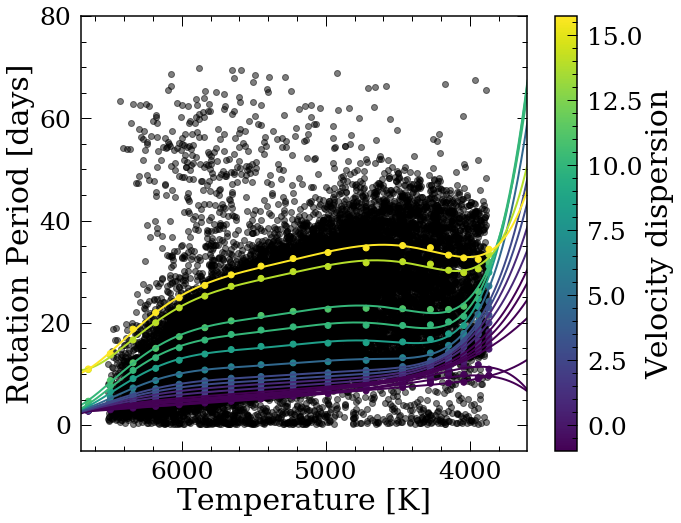

In [47]:
Model_df=pd.DataFrame(np.array((VD_single)).T,columns=['VD'])
Model_df=pd.concat([Model_df,pd.DataFrame(Prot.T,columns=['Prot'+str(i) for i in range(len(Prot))])],axis=1, sort=False)

Model_df_1d=pd.DataFrame(np.array((Teff_model_1d,Prot_model_1d,VD_model_1d)).T,columns=['Teff','Prot','VD'])

VDDic={'Prot'+str(i):Teff_single[i] for i in range(len(Prot))}

p_model=[]

for i in range(len(Model_df)):
    fitModel = np.polyfit(Teff_single, Model_df.loc[i][['Prot'+str(i) for i in range(len(Prot))]].values, 6)
    p_model.append(np.poly1d(fitModel))

    
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
v_max,v_min=max(VD_single),min(VD_single)

plt.scatter(df['teff_calc'],df['Prot'],c='k',vmax=v_max,vmin=v_min,alpha=0.5)
for i in range(len(p_model)):
    plt.plot(range(3000,7000),p_model[i](range(3000,7000)),c=cm(VD_single[i]/(v_max-v_min)))
    plt.scatter(Teff_model[:,i],Prot[:,i],c=VD_model[:,i],vmax=v_max,vmin=v_min)
    #plt.plot(Teff_model[:,i],Prot[:,i],'--',c=cm(VD_single[i]/(v_max-v_min)))
    
df=df.loc[df['teff_calc']>3300]
plt.xlim([3600,6700])
plt.ylim([-5,80])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')
plt.xlabel('Temperature [K]')
cb=plt.colorbar()
cb.set_label('Velocity dispersion')
plt.savefig('VDmodel.png')

# Mocked velocity dispersion

In [48]:
df_vd=pd.read_pickle('MockTruth.pkl')

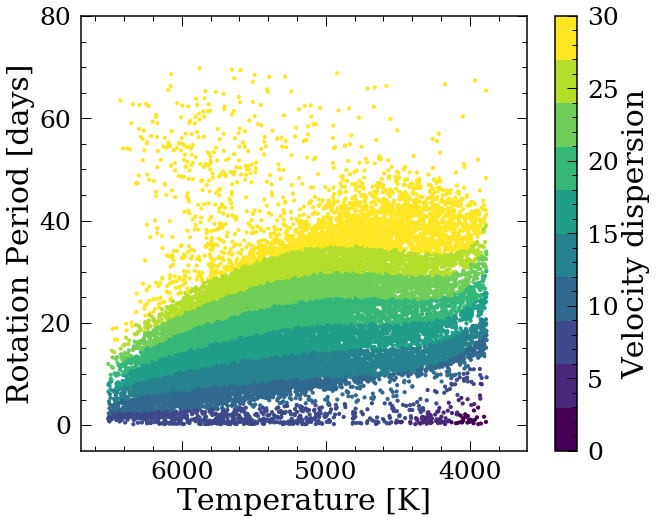

In [49]:
v_max,v_min=30,0
cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(10,8))
plt.scatter(df_vd['teff'],df_vd['Prot'],c=df_vd['dv_true'],s=10,vmax=v_max,vmin=0,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3600,6700])
plt.ylim([-5,80])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Velocity dispersion')
plt.savefig('./MockTruth.png')

# Recovering VD with NN and bin methods and find the optimum bin/NN size

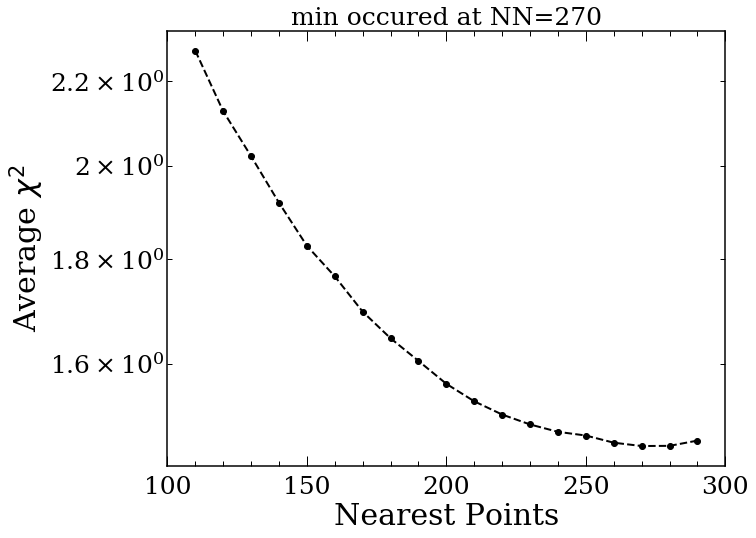

In [50]:
NNarrays=np.load('NN_test.npy')
chidq=np.load('NN_test_chidq.npy')

plt.figure(figsize=(10,8))
plt.semilogy(NNarrays[10:],chidq[10:],'ko--')
plt.ylabel('Average $\chi^2$')
plt.xlabel('Nearest Points')
oldchi=chidq[0]
minNN=0
for i in range(len(NNarrays)):
    if chidq[i]<oldchi:
        minNN=NNarrays[i]
        oldchi=chidq[i]
plt.title('min occured at NN=%d'%(minNN),fontsize=25)

plt.xlim([100,300])

plt.savefig('NN_size.png')

/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0.8243988876352031 577.2727272727273 0.1118181818181818


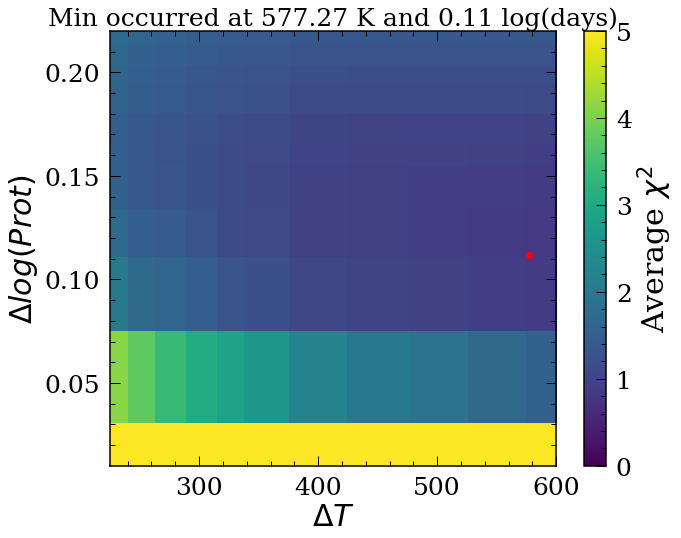

In [51]:
from scipy.interpolate import griddata

bintemps=[225,250,275,300,325,350,400,450,500,550,600]
binprots=[0.01,0.05,0.1,0.12,0.15,0.16,0.17,0.19,0.2,0.21,0.22]

data=pd.read_table('../BinTESTS',delimiter=',')
for i in bintemps:
    data['prot'].loc[data['temp']==i]=binprots

temps_a=data['temp'].values
bins_a=data['prot'].values
chidq_bin=data['chisq'].values

"""
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(temps_a,bins_a,c=chidq_bin,cmap=cm,s=100)
cb=plt.colorbar()
cb.set_label('$\chi^2$')
"""
temp_g=np.linspace(min(bintemps),max(bintemps),100)
rot_g=np.linspace(min(binprots),max(binprots),100)
grid_x, grid_y = np.meshgrid(temp_g,rot_g)

points=np.zeros((len(temps_a),2))
points[:,0]=temps_a
points[:,1]=bins_a
grid_z1 = griddata(points, chidq_bin, (grid_x, grid_y), method='nearest')


temp_min=0
Prot_min=0
grid_z1=grid_z1.T
oldele=grid_z1[0][0]

finali=0
finalj=0
for i in range(len(grid_z1)):
    for j in range(len(grid_z1[i])):
        if grid_z1[i,j]<oldele:
            finali=i
            finalj=j
            temp_min=temp_g[i]
            Prot_min=rot_g[j]
            oldele=grid_z1[i,j]
print(oldele,temp_min,Prot_min)


plt.figure(figsize=(10,8))
plt.imshow(grid_z1.T, extent=(min(bintemps),max(bintemps),min(binprots),max(binprots)), origin='lower', aspect='auto',vmin=0,vmax=5)
plt.plot(temp_min,Prot_min,'ro')
plt.xlabel('$\Delta T$')
plt.ylabel('$\Delta log(Prot)$')
cb=plt.colorbar()
cb.set_label('Average $\chi^2$')
plt.title('Min occurred at %.2f K and %.2f log(days)'%(temp_min,Prot_min),fontsize=25)
plt.savefig('binsize.png')


# Recover velocity dispersion using the best parameters

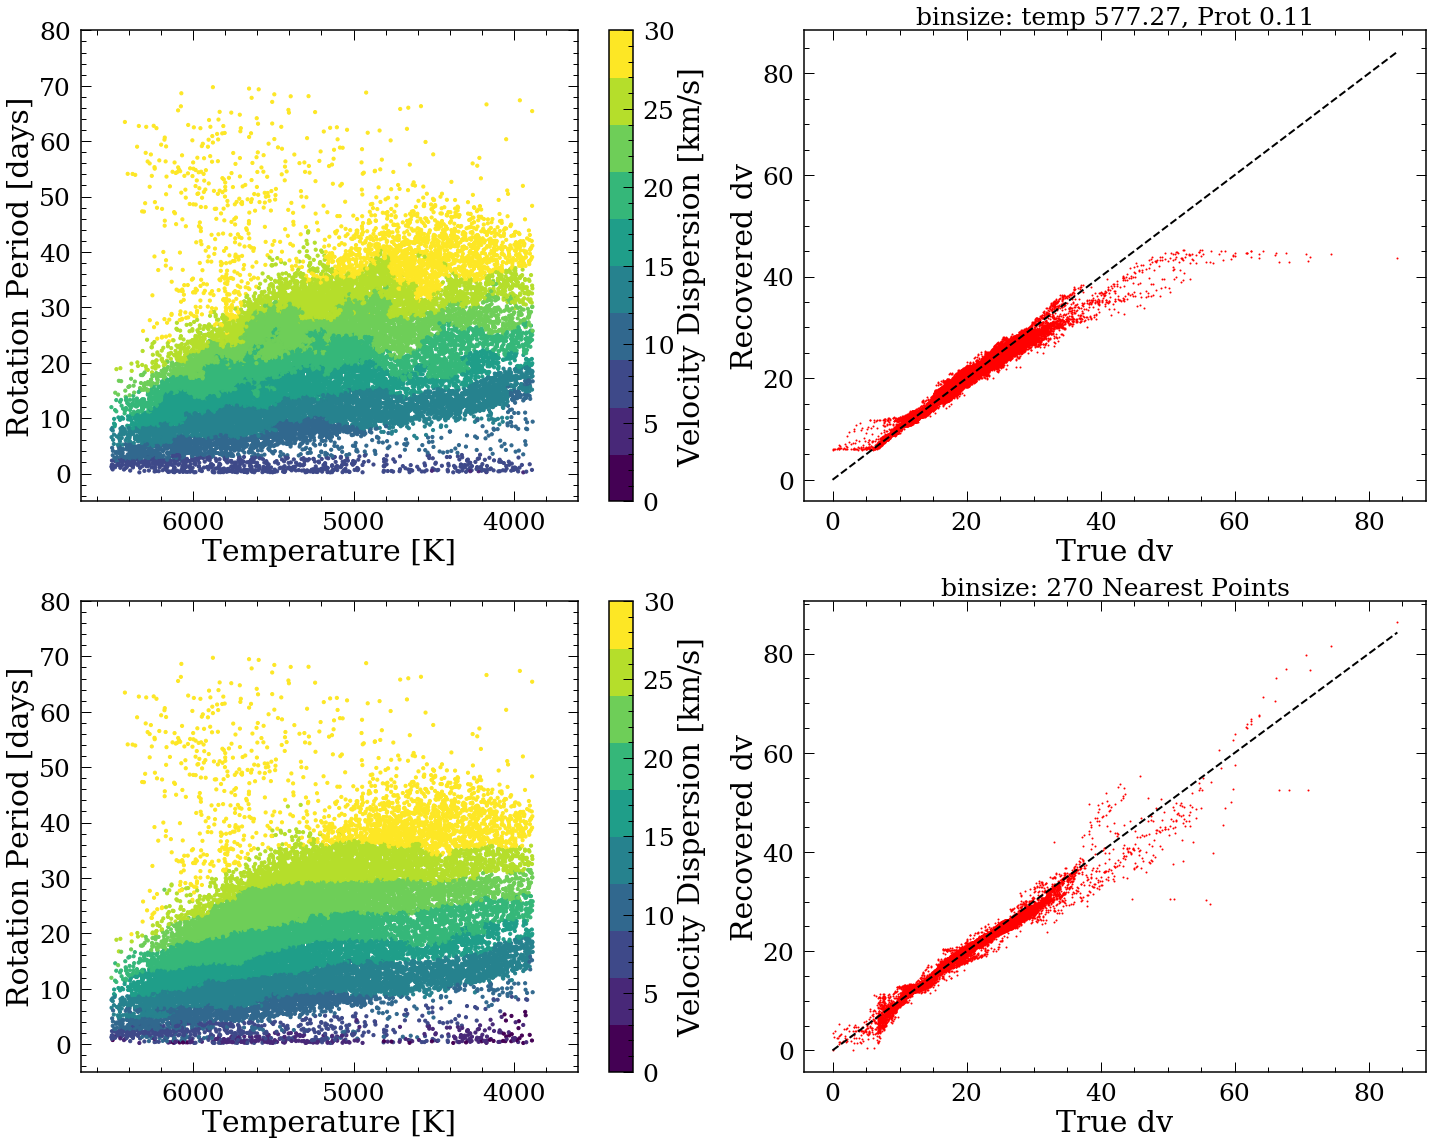

In [52]:
recover_nn=pd.read_pickle('recover_nn.pkl')
recover_bin=pd.read_pickle('recover_bin.pkl')

cm = plt.cm.get_cmap('viridis',10)
plt.figure(figsize=(20,16))
plt.subplot(2,2,1)
plt.scatter(recover_nn['teff'],recover_nn['Prot'],c=recover_nn['dv_recover'],
            vmax=30,vmin=0,s=10,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3600,6700])
plt.ylim([-5,80])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Velocity Dispersion [km/s]')

plt.subplot(2,2,2)
plt.scatter(recover_nn['dv_true'],recover_nn['dv_recover'],s=1,c='r')
plt.plot([min(recover_nn['dv_true']),max(recover_nn['dv_true'])],
         [min(recover_nn['dv_true']),max(recover_nn['dv_true'])],'k--')
plt.title('binsize: temp %.2f, Prot %.2f'%(577.27,0.11),fontsize=25)
plt.ylabel('Recovered dv')
plt.xlabel('True dv')

plt.subplot(2,2,3)
plt.scatter(recover_bin['teff'],recover_bin['Prot'],c=recover_bin['dv_recover'],
            vmax=30,vmin=0,s=10,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.xlim([3600,6700])
plt.ylim([-5,80])
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Velocity Dispersion [km/s]')

plt.subplot(2,2,4)
plt.scatter(recover_bin['dv_true'],recover_bin['dv_recover'],s=1,c='r')
plt.plot([min(recover_bin['dv_true']),max(recover_bin['dv_true'])],
         [min(recover_bin['dv_true']),max(recover_bin['dv_true'])],'k--')
plt.title('binsize: %d Nearest Points'%(270),fontsize=25)
plt.ylabel('Recovered dv')
plt.xlabel('True dv')
plt.tight_layout()
plt.savefig('Recovering_bin_nn.png')


# Use bin method to get age

## For Prot

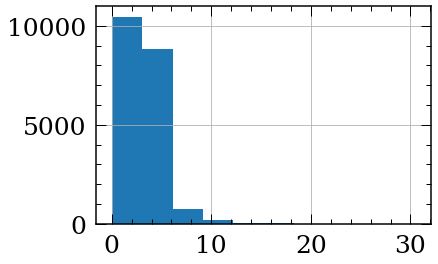

In [3]:
fname_bin='minchisq.pkl'

df_bin=pd.read_pickle('../'+fname_bin)
df_bin=df_bin.dropna(subset=['kin_age','iso_age'])
df_bin.kin_age.hist()

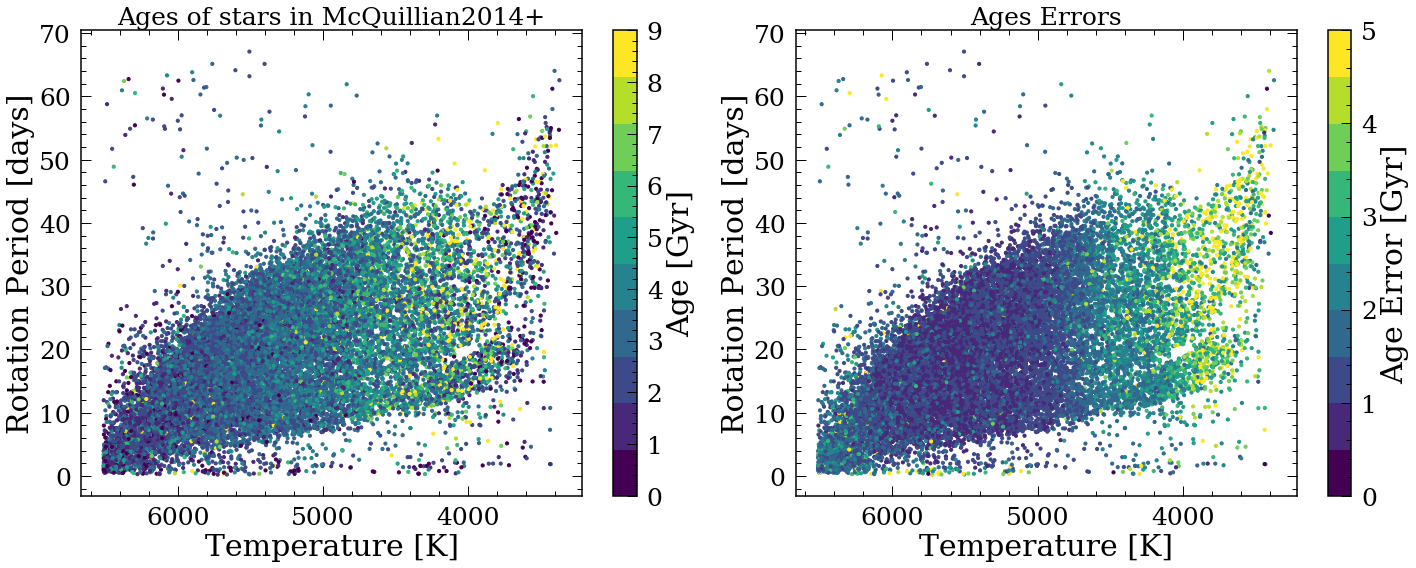

In [5]:
plt.figure(figsize=(20,8))
cm = plt.cm.get_cmap('viridis',10)
plt.subplot(1,2,1)
plt.scatter(df_bin['teff_calc'],df_bin['Prot'],c=df_bin['kin_age'],s=10,vmin=0,vmax=9,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Ages of stars in McQuillian2014+',fontsize=25)

plt.subplot(1,2,2)
plt.scatter(df_bin['teff_calc'],df_bin['Prot'],c=df_bin['kin_age_err_bs'],s=10,vmin=0,vmax=5,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Age Error [Gyr]')
plt.title('Ages Errors',fontsize=25)
plt.tight_layout()

plt.savefig('Age_recover.png')


## For Rvar

84125


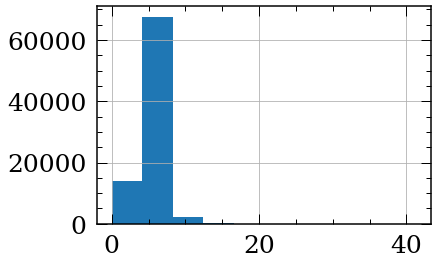

In [116]:
fname_bin='minchisq_rvar.pkl'

df_bin_rvar=pd.read_pickle('../'+fname_bin)
df_bin_rvar=df_bin_rvar.dropna(subset=['kin_age','iso_age'])
df_bin_rvar.kin_age.hist()
print(len(df_bin_rvar))

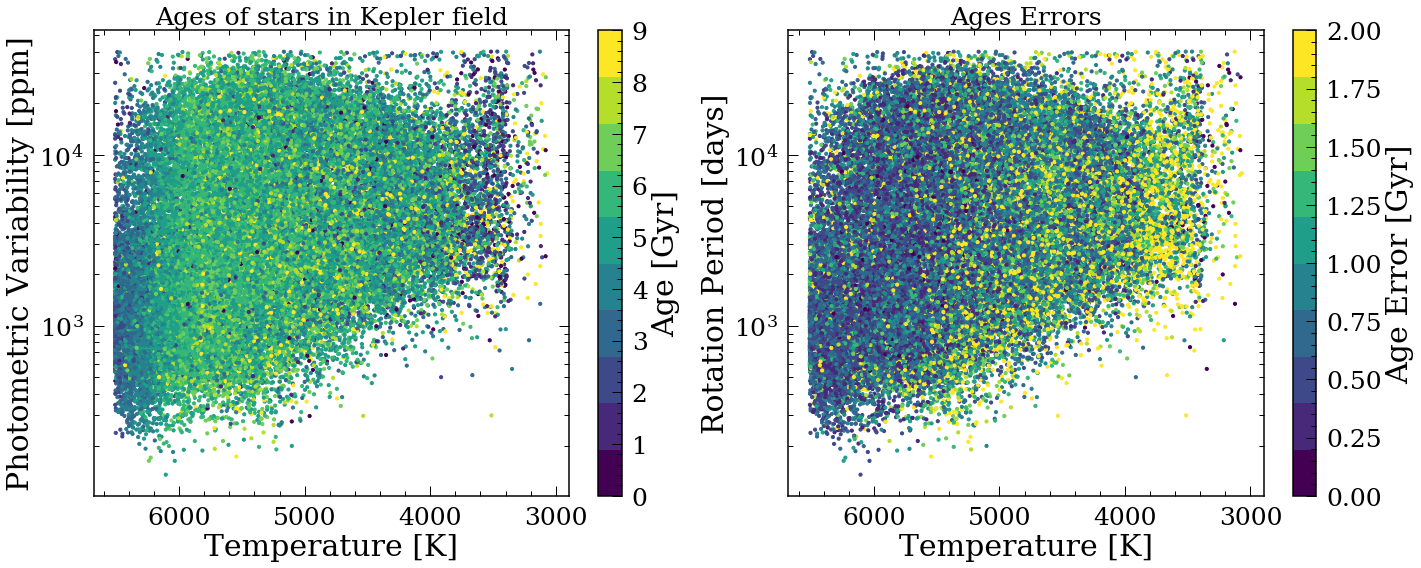

In [117]:
plt.figure(figsize=(20,8))
cm = plt.cm.get_cmap('viridis',10)
plt.subplot(1,2,1)
plt.scatter(df_bin_rvar['teff_calc'],df_bin_rvar['Rvar'],c=df_bin_rvar['kin_age'],s=10,vmin=0,vmax=9,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.ylabel('Photometric Variability [ppm]')

cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Ages of stars in Kepler field',fontsize=25)

plt.subplot(1,2,2)
plt.scatter(df_bin_rvar['teff_calc'],df_bin_rvar['Rvar'],c=df_bin_rvar['kin_age_err'],s=10,vmin=0,vmax=2,cmap=cm,edgecolors=None)

plt.xlabel('Temperature [K]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.ylabel('Rotation Period [days]')

cb=plt.colorbar()
cb.set_label('Age Error [Gyr]')
plt.title('Ages Errors',fontsize=25)
plt.tight_layout()

plt.savefig('Age_recover_rvar.png')



# Compare to isochrone ages


## For Prot

binned in [log(Prot),teff,abs_G]=[2,366.67,0.01]

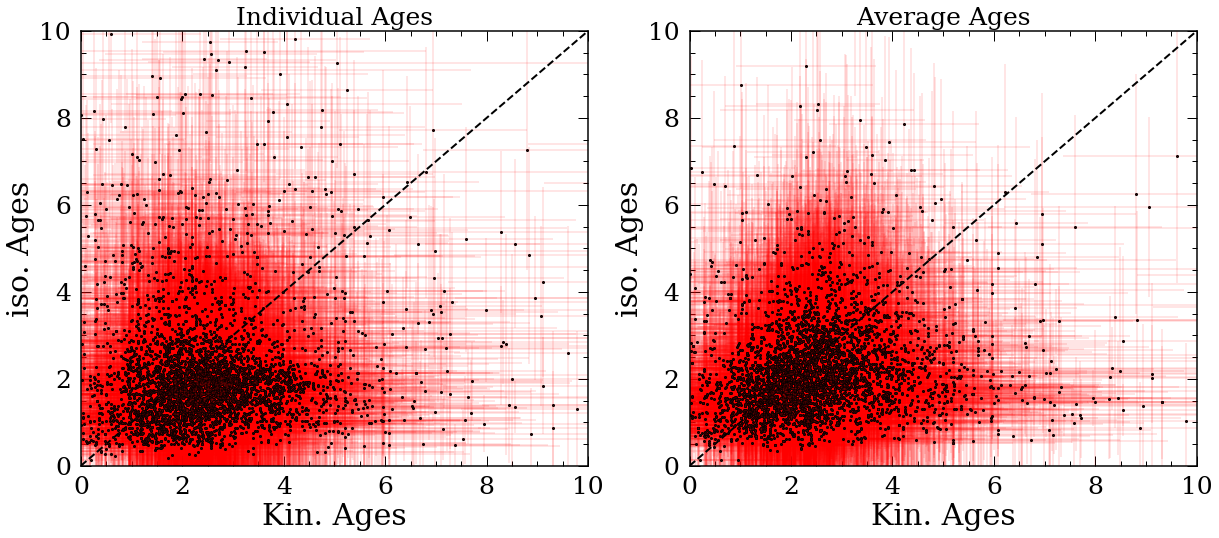

In [6]:
df_bin['iso_age_err']=np.sqrt(df_bin['iso_age_err1']**2+df_bin['iso_age_err2']**2)

df_bin_plot=df_bin.loc[df_bin['iso_age']<10]
df_bin_plot=df_bin_plot.loc[df_bin_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_bin_plot['kin_age'], df_bin_plot['iso_age'],
             yerr=df_bin_plot['iso_age_err1'],xerr=df_bin_plot['kin_age_err_bs'],
             fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_bin_plot['kin_age'], df_bin_plot['iso_age'],'ko',alpha=1,markersize=2)

plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.title('Individual Ages',fontsize=25)

plt.subplot(1,2,2)
plt.errorbar(df_bin_plot['kin_age'], df_bin_plot['iso_age_ave'],
             yerr=df_bin_plot['iso_age_err1'],xerr=df_bin_plot['kin_age_err_bs'],
             fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_bin_plot['kin_age'], df_bin_plot['iso_age_ave'],'ko',alpha=1,markersize=2)

plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.title('Average Ages',fontsize=25)
plt.savefig('Iso_kin_ages.png')


## For Rvar

binned in [log(Rvar),teff,abs_G]=[5,266.67,0.01]

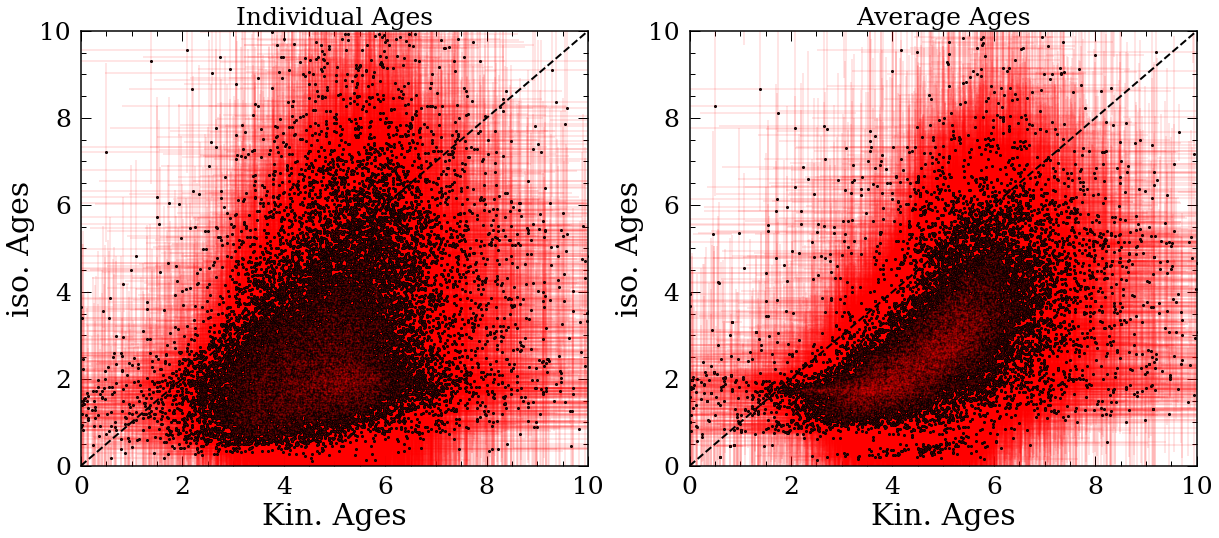

In [118]:
df_bin_rvar['iso_age_err']=np.sqrt(df_bin_rvar['iso_age_err1']**2+df_bin_rvar['iso_age_err2']**2)

df_bin_plot_rvar=df_bin_rvar.loc[df_bin_rvar['iso_age']<10]
df_bin_plot_rvar=df_bin_plot_rvar.loc[df_bin_plot_rvar['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_bin_plot_rvar['kin_age'], df_bin_plot_rvar['iso_age'],
             yerr=df_bin_plot_rvar['iso_age_err1'],xerr=df_bin_plot_rvar['kin_age_err'],
             fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_bin_plot_rvar['kin_age'], df_bin_plot_rvar['iso_age'],'ko',alpha=1,markersize=2)

plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.title('Individual Ages',fontsize=25)

plt.subplot(1,2,2)
plt.errorbar(df_bin_plot_rvar['kin_age'], df_bin_plot_rvar['iso_age_ave'],
             yerr=df_bin_plot_rvar['iso_age_err1'],xerr=df_bin_plot_rvar['kin_age_err'],
             fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_bin_plot_rvar['kin_age'], df_bin_plot_rvar['iso_age_ave'],'ko',alpha=1,markersize=2)

plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.title('Average Ages',fontsize=25)
plt.savefig('Iso_kin_ages_rvar.png')



# Compare to AS stars

## For Prot

In [7]:
ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])
ASstars

Clusters_cm=pd.merge(ASstars,df_bin,left_on='KIC',right_on='KID',how='inner')
Clusters_cm


Pipe       KIC_x    Mass     Rad  log(g)     Age     Lum       rho  \
0       AST      3735871.0  1.1112  1.1014  4.3995  1.8414  1.5230  1.171100   
1       BASTA    3735871.0  1.0890  1.0957  4.3956  2.3457  1.5040  1.169009   
2       C2kSMO   3735871.0  1.0757  1.0858  4.3979  1.4544  1.4300  1.183600   
3       GOE      3735871.0  1.1057  1.0978  4.4004  1.6456  1.5186  1.177094   
4   V&amp;A      3735871.0  1.1050  1.0990  4.3992  1.7710  1.4540  1.172499   
5       YMCM     3735871.0  1.1316  1.1084  4.4017  1.9465  0.1854  1.169900   
6       AST      8179536.0  1.1977  1.3396  4.2619  2.7851  2.6220  0.701500   
7       BASTA    8179536.0  1.1593  1.3266  4.2548  3.5434  2.5710  0.697301   
8       C2kSMO   8179536.0  1.2597  1.3520  4.2760  1.7632  2.5720  0.718000   
9       GOE      8179536.0  1.2280  1.3471  4.2682  1.6766  2.6600  0.707618   
10  V&amp;A      8179536.0  1.2580  1.3520  4.2742  1.7090  2.6400  0.717868   
11      YMCM     8179536.0  1.2346  1.3542  4.2656  2.6906  0.4276  0.699830   
12      AST      9139151.0  1.1483  1.1499  4.3763  2.4324  1.8510  1.063400   
13      BASTA    9139151.0  1.1783  1.1526  4.3824  1.3236  1.8550  1.075444   
14      C2kSMO   9139151.0  1.2167  1.1695  4.3869  1.3428  1.8570  1.071600   
15      GOE      9139151.0  1.1434  1.1451  4.3784  1.9517  1.8441  1.072619   
16  V&amp;A      9139151.0  1.1080  1.1340  4.3732  1.7640  1.8000  1.070850   
17      YMCM     9139151.0  1.1926  1.1650  4.3813  2.3401  0.2791  1.061800   
18      AST     10644253.0  1.1371  1.1100  4.4027  1.1767  1.4850  1.170800   
19      BASTA   10644253.0  1.0985  1.0987  4.3956  2.3936  1.4530  1.164403   
20      C2kSMO  10644253.0  1.1726  1.1209  4.4078  0.9427  1.4810  1.172900   
21      GOE     10644253.0  1.1340  1.1089  4.4027  1.1384  1.4315  1.171447   
22  V&amp;A     10644253.0  1.1180  1.1050  4.4008  1.0080  1.4710  1.171950   
23      YMCM    10644253.0  1.1748  1.1221  4.4074  1.0644  0.1791  1.170600   
24      AST     11081729.0  1.3153  1.4359  4.2423  1.9282  3.3950  0.625600   
25      BASTA   11081729.0  1.2980  1.4226  4.2449  1.8825  3.2770  0.635920   
26      C2kSMO  11081729.0  1.3227  1.4172  4.2563  0.8216  3.3680  0.654600   
27      GOE     11081729.0  1.4985  1.4852  4.2700  0.8329  3.8699  0.644329   
28  V&amp;A     11081729.0  1.2560  1.4150  4.2345  2.1670  3.0990  0.622740   
29      YMCM    11081729.0  1.3383  1.4428  4.2455  1.8389  0.5358  0.627190   

      Dist    Xini  ...   v_t_err   v_b_err  abs_G_err  teff_val_err  \
0   124.05  0.7070  ...  0.058978  0.026661   0.006961    244.977539   
1   123.40  0.7080  ...  0.058978  0.026661   0.006961    244.977539   
2   122.29  0.6920  ...  0.058978  0.026661   0.006961    244.977539   
3   123.64  0.7105  ...  0.058978  0.026661   0.006961    244.977539   
4   123.77  0.7090  ...  0.058978  0.026661   0.006961    244.977539   
5   124.84  0.7210  ...  0.058978  0.026661   0.006961    244.977539   
6   139.50  0.7080  ...  0.137377  0.047300   0.011204    170.712646   
7   138.14  0.7170  ...  0.137377  0.047300   0.011204    170.712646   
8   140.81  0.7200  ...  0.137377  0.047300   0.011204    170.712646   
9   140.29  0.6569  ...  0.137377  0.047300   0.011204    170.712646   
10  140.81  0.7150  ...  0.137377  0.047300   0.011204    170.712646   
11  141.03  0.7195  ...  0.137377  0.047300   0.011204    170.712646   
12  101.18  0.7020  ...  0.082901  0.023701   0.005605    129.425049   
13  101.43  0.7080  ...  0.082901  0.023701   0.005605    129.425049   
14  102.91  0.7100  ...  0.082901  0.023701   0.005605    129.425049   
15  100.76  0.7116  ...  0.082901  0.023701   0.005605    129.425049   
16   99.78  0.6650  ...  0.082901  0.023701   0.005605    129.425049   
17  102.51  0.7180  ...  0.082901  0.023701   0.005605    129.425049   
18   93.85  0.6980  ...  0.056196  0.031497   0.005054    112.196289   
19   92.89  0.6980  ...  0.056196  0.031497   0.005054    112.196289   
20   94.77  0.714

/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


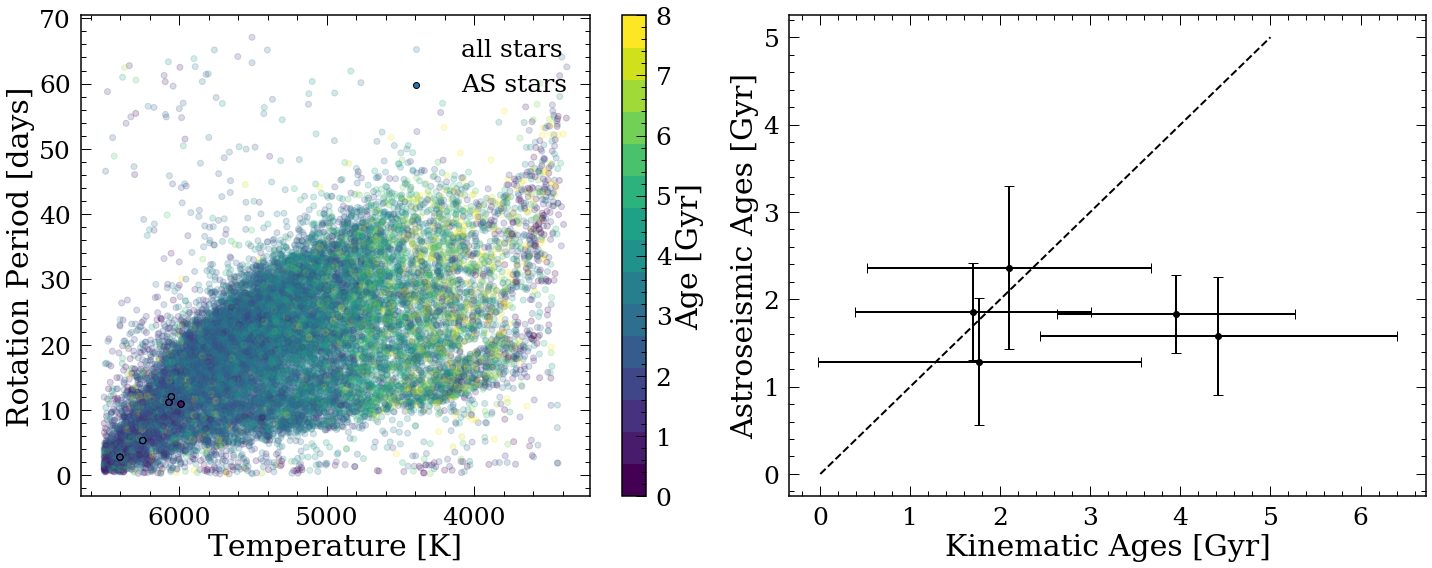

In [8]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df_bin['teff_calc'],df_bin['Prot'],
            c=df_bin['kin_age'],cmap=cm,vmin=0,vmax=8,alpha=0.2,label='all stars')
plt.scatter(Clusters_cm['teff_calc'],Clusters_cm['Prot'],
            c=Clusters_cm['Age'],cmap=cm,vmin=0,vmax=8,edgecolor='k',label='AS stars')
cb=plt.colorbar()
plt.legend()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')



plt.subplot(1,2,2)
pcount=1

starASage=[]
starASage_err=[]
kinage=[]
kinage_err=[]
isoage=[]
isoage_err=[]

plt.plot([0,5],[0,5],'k--')

for star in Clusters_cm['KID'].unique():
    plotCM=Clusters_cm.loc[Clusters_cm['KID']==star]
    starASage.append(np.mean(plotCM['Age']))
    starASage_err.append((max(plotCM['Age'])-min(plotCM['Age']))/2.)
    kinage.append(plotCM['kin_age'].values[0])
    kinage_err.append(plotCM['kin_age_err_bs'].values[0])
    isoage.append(plotCM['iso_age'].values[0])
    isoage_err.append(plotCM['iso_age_err'].values[0])

plt.errorbar(kinage,starASage,xerr=kinage_err,yerr=starASage_err,fmt='ko',capsize=5)
#plt.errorbar(isoage,starASage,xerr=isoage_err,yerr=starASage_err,fmt='ro',capsize=5)
    
plt.ylabel('Astroseismic Ages [Gyr]')
plt.xlabel('Kinematic Ages [Gyr]')
r = np.corrcoef(plotCM["Age"], plotCM["kin_age"])

plt.tight_layout()

plt.savefig('ASstars.png')

## For Rvar

In [141]:
Clusters_cm_rvar=pd.merge(ASstars,df_bin_rvar,left_on='KIC',right_on='KID',how='inner')
Clusters_cm_rvar



Pipe       KIC_x    Mass     Rad  log(g)      Age     Lum       rho  \
0       AST      3427720.0  1.0990  1.1145  4.3844   2.3521  1.5030  1.117800   
1       BASTA    3427720.0  1.1080  1.1167  4.3868   2.2339  1.5790  1.121488   
2       C2kSMO   3427720.0  1.1016  1.1127  4.3869   2.3038  1.5250  1.126200   
3       GOE      3427720.0  1.0920  1.1108  4.3849   2.3367  1.4831  1.122443   
4   V&amp;A      3427720.0  1.0770  1.1050  4.3838   2.3040  1.5190  1.125990   
..         ...         ...     ...     ...     ...      ...     ...       ...   
85      BASTA   11772920.0  0.8287  0.8438  4.5001  10.6660  0.4870  1.926522   
86      C2kSMO  11772920.0  0.8181  0.8424  4.4995  10.6479  0.4480  1.927600   
87      GOE     11772920.0  0.7810  0.8289  4.4934   9.8981  0.4697  1.931094   
88  V&amp;A     11772920.0  0.7778  0.8276  4.4943   9.4830  0.4800  1.932350   
89      YMCM    11772920.0  0.8506  0.8537  4.5046  10.8050  0.3112  1.924800   

     Dist    Xini  ...    teff_calc  Rvar_log   logg        v_b     abs_G  \
0   90.93  0.7060  ...  6018.698508  2.683980  4.378  12.023812  4.177233   
1   91.11  0.7030  ...  6018.698508  2.683980  4.378  12.023812  4.177233   
2   90.79  0.7220  ...  6018.698508  2.683980  4.378  12.023812  4.177233   
3   90.62  0.7153  ...  6018.698508  2.683980  4.378  12.023812  4.177233   
4   90.15  0.7120  ...  6018.698508  2.683980  4.378  12.023812  4.177233   
..    ...     ...  ...          ...       ...    ...        ...       ...   
85  69.68  0.7030  ...  5306.795495  2.625681  4.440 -22.856726  5.396070   
86  69.56  0.7030  ...  5306.795495  2.625681  4.440 -22.856726  5.396070   
87  68.45  0.6622  ...  5306.795495  2.625681  4.440 -22.856726  5.396070   
88  68.34  0.6640  ...  5306.795495  2.625681  4.440 -22.856726  5.396070   
89  70.50  0.7239  ...  5306.795495  2.625681  4.440 -22.856726  5.396070   

    iso_age_err   kin_age  iso_age_ave  iso_age_ave_err  kin_age_err  
0      3.198031  5.845594     4.359223           387.75     0.549438  
1      3.198031  5.845594     4.359223           387.75     0.549438  
2      3.198031  5.845594     4.359223           387.75     0.549438  
3      3.198031  5.845594     4.359223           387.75     0.549438  
4      3.198031  5.845594     4.359223           387.75     0.549438  
..          ...       ...          ...              ...          ...  
85     7.241996  5.942126     8.245560           340.38     1.300455  
86     7.241996  5.942126     8.245560           340.38     1.300455  
87     7.241996  5.942126     8.245560           340.38     1.300455  
88     7.241996  5.942126     8.245560           340.38     1.300455  
89     7.241996  5.942126     8.245560           340.38     1.300455  

[90 rows x 64 columns]

/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


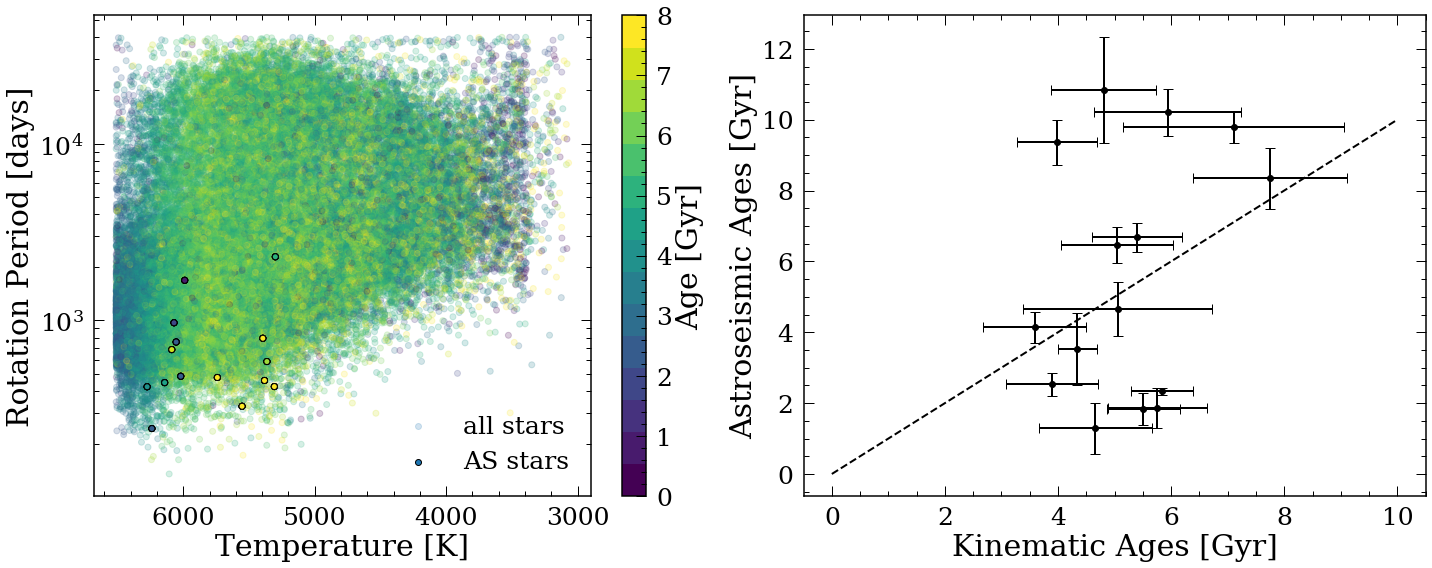

In [142]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df_bin_rvar['teff_calc'],df_bin_rvar['Rvar'],
            c=df_bin_rvar['kin_age'],cmap=cm,vmin=0,vmax=8,alpha=0.2,label='all stars')
plt.scatter(Clusters_cm_rvar['teff_calc'],Clusters_cm_rvar['Rvar'],
            c=Clusters_cm_rvar['Age'],cmap=cm,vmin=0,vmax=8,edgecolor='k',label='AS stars')
cb=plt.colorbar()
plt.legend()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')



plt.subplot(1,2,2)
pcount=1

starASage=[]
starASage_err=[]
kinage=[]
kinage_err=[]
isoage=[]
isoage_err=[]

plt.plot([0,10],[0,10],'k--')

for star in Clusters_cm_rvar['KID'].unique():
    plotCM=Clusters_cm_rvar.loc[Clusters_cm_rvar['KID']==star]
    starASage.append(np.mean(plotCM['Age']))
    starASage_err.append((max(plotCM['Age'])-min(plotCM['Age']))/2.)
    kinage.append(plotCM['kin_age'].values[0])
    kinage_err.append(plotCM['kin_age_err'].values[0])
    isoage.append(plotCM['iso_age'].values[0])
    isoage_err.append(plotCM['iso_age_err'].values[0])

plt.errorbar(kinage,starASage,xerr=kinage_err,yerr=starASage_err,fmt='ko',capsize=5)
#plt.errorbar(isoage,starASage,xerr=isoage_err,yerr=starASage_err,fmt='ro',capsize=5)
    
plt.ylabel('Astroseismic Ages [Gyr]')
plt.xlabel('Kinematic Ages [Gyr]')
r = np.corrcoef(plotCM["Age"], plotCM["kin_age"])

plt.tight_layout()

plt.savefig('ASstars_rvar.png')

# Individual abundances for solar twins
Magan Bedell abundances: https://ui.adsabs.harvard.edu/abs/2018ApJ...865...68B/abstract
Fe/H and ages: https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.2580S/abstract

## For Prot

In [95]:
df_st=pd.read_pickle('solartwins.pkl')
df_st=df_st.loc[abs(df_st['teff_calc']-5778)<=100]
df_st=df_st.loc[abs(df_st['LOGG']-4.43)<=0.1]
print(len(df_st))
df_ka=pd.read_table('../BedellAbund.csv',delimiter=',')
df_ka.HIP=[int(i) for i in df_ka.HIP.values]
df_ka_age=pd.read_table('../Bedell_age.csv',delimiter=',')
df_ka_age.HIP=[int(i) for i in df_ka_age.HIP.values]
df_fe=pd.read_table('../Bedell_Fe.csv',delimiter=',')
df_fe.HIP=[int(i) for i in df_fe.HIP.values]

11


In [96]:
df_st_md=pd.merge(df_ka,df_ka_age,left_on='HIP',right_on='HIP',how='inner')
df_st_md=pd.merge(df_st_md,df_fe,left_on='HIP',right_on='HIP',how='inner')
df_st_md.columns

Index(['HIP', '[CI/H]', '[CH/H]', '[OI/H]', '[NaI/H]', '[MgI/H]', '[AlI/H]',
       '[SiI/H]', '[SI/H]', '[CaI/H]', '[ScI/H]', '[ScII/H]', '[TiI/H]',
       '[TiII/H]', '[VI/H]', '[CrI/H]', '[CrII/H]', '[MnI/H]', '[CoI/H]',
       '[NiI/H]', '[CuI/H]', '[ZnI/H]', '_RA', '_DE', 'recno', 'e_[ZnI/H]',
       'e_[VI/H]', 'e_[TiII/H]', 'e_[SiI/H]', 'e_[TiI/H]', 'e_[SI/H]',
       'e_[ScII/H]', 'e_[ScI/H]', 'e_[OI/H]', 'e_[NiI/H]', 'e_[NaI/H]',
       'e_[MnI/H]', 'e_[MgI/H]', 'e_[CuI/H]', 'e_[AlI/H]', 'e_[CaI/H]',
       'e_[CH/H]', 'e_[CI/H]', 'e_[CoI/H]', 'e_[CrI/H]', 'e_[CrII/H]',
       'RAJ2000_x', 'DEJ2000_x', 'Agemp', 'AgeLL1s', 'AgeUL1s', 'AgeLL2s',
       'AgeUL2s', 'Agemean', 'Agestd', 'Massmp', 'MassLL1s', 'MassUL1s',
       'MassLL2s', 'MassUL2s', 'MassMean', 'MassStd', 'RAJ2000_y', 'DEJ2000_y',
       'SNR', 'Teff', 'e_Teff', 'logg', 'e_logg', '[Fe/H]', 'e_[Fe/H]', 'Xi',
       'e_Xi'],
      dtype='object')

In [97]:
abun_apog=['C_FE','MG_FE','AL_FE','SI_FE','S_FE','CA_FE','TI_FE','CR_FE','MN_FE','CO_FE',
       'NI_FE','CU_FE']

abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/'}

Progress: [##################--] 91.7%


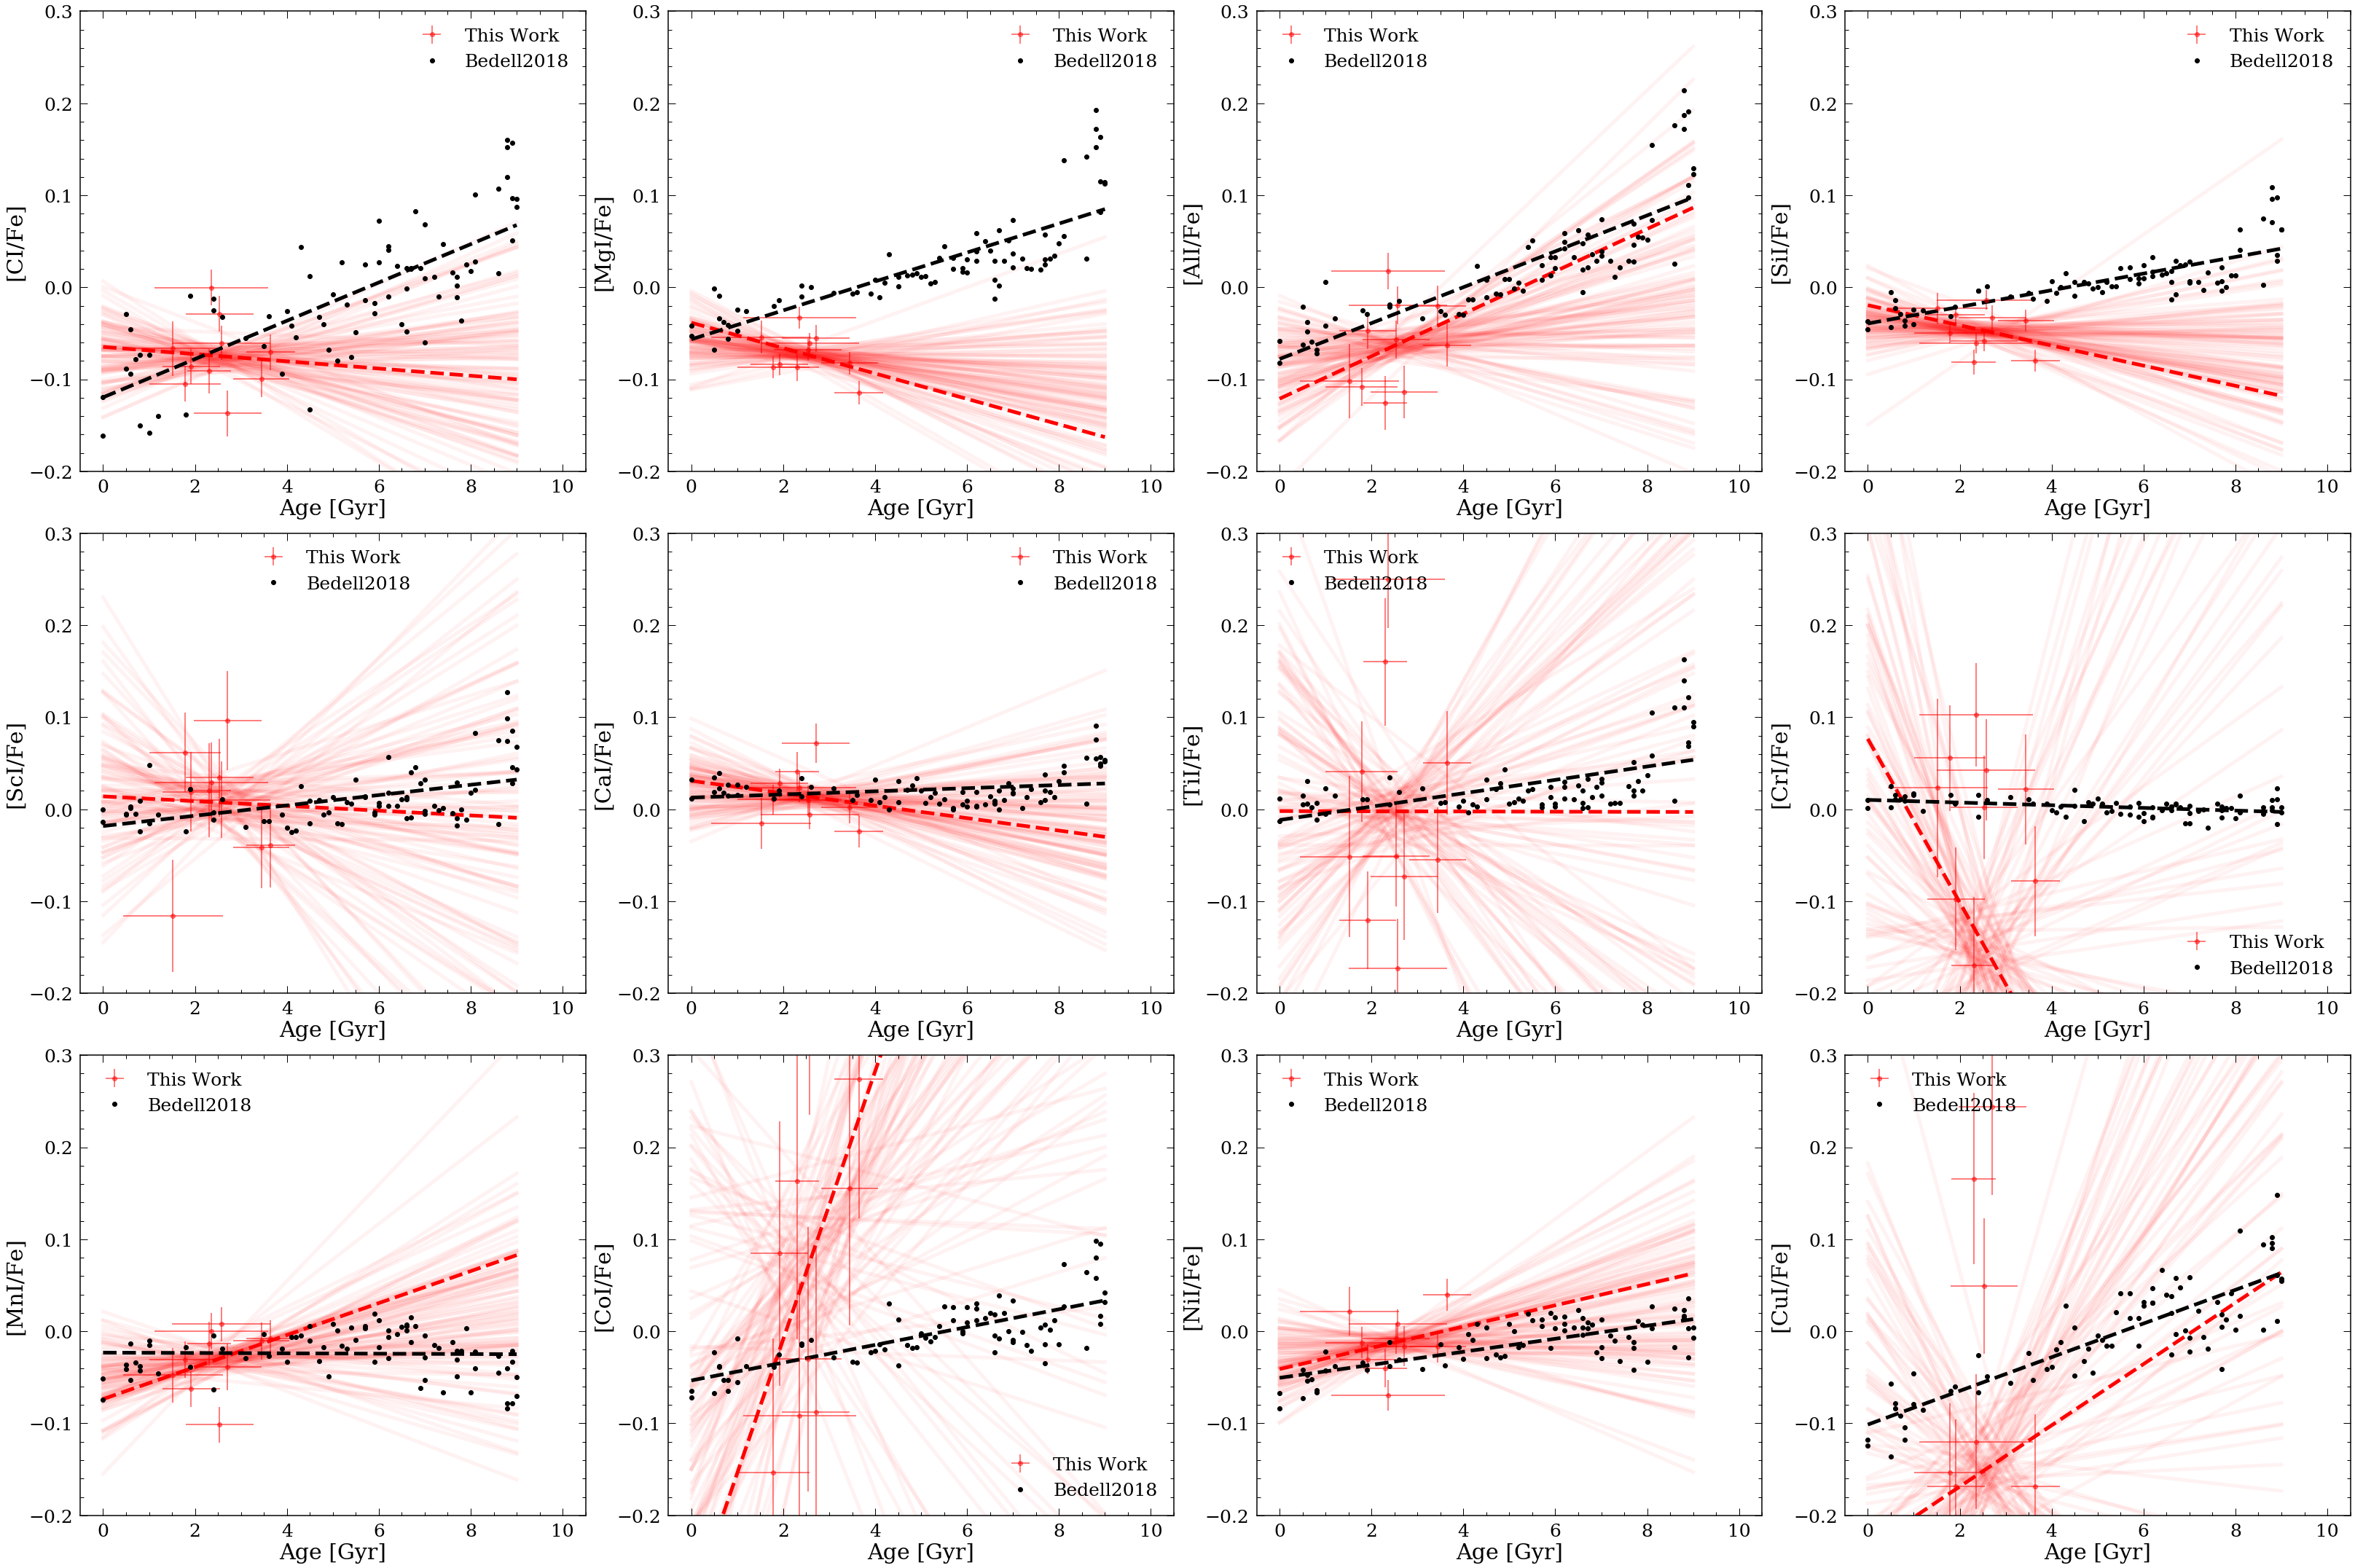

In [98]:
plt.figure(figsize=(45,30))
for i in range(len(abun_apog)):
    update_progress(i/len(abun_apog))
    df_plot=df_st.loc[df_st[abun_apog[i]]>-100]
    df_plot=df_plot.reset_index(drop=True)
    df_plot=df_plot.dropna(subset=['kin_age','kin_age_err'])
    plt.subplot(3,4,i+1)
    
    #err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)+np.power(df_plot["age_STD_err"],2.)
    err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)
    
    
    plt.errorbar(df_plot['kin_age'],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],
                 xerr=df_plot["kin_age_err"],fmt='ro',label='This Work',alpha=0.5)
    """
    plt.errorbar(df_plot['age_MAD'],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],fmt='ro',label='This Work',alpha=0.5)
    """
    
    z = np.polyfit(df_plot['kin_age'],df_plot[abun_apog[i]],1)
    p = np.poly1d(z)
    plt.plot(range(10),p(range(10)),'r--',linewidth=5)
        
    for k in range(100):
        new_age_mock=np.array([np.random.normal(df_plot.iloc[j]['kin_age'],
                        df_plot.iloc[j]['kin_age_err']) for j in range(len(df_plot))])
        new_abun_mock=np.array([np.random.normal(df_plot.iloc[j][abun_apog[i]], 
                        df_plot.iloc[j][abun_apog[i]+"_ERR"]) for j in range(len(df_plot))])
        z = np.polyfit(new_age_mock,new_abun_mock,1)
        p = np.poly1d(z)
        plt.plot(range(10),p(range(10)),'r-',linewidth=5,alpha=0.05)
    
    z = np.polyfit(df_st_md['Agemp'], df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],1)
    p = np.poly1d(z)
    
    plt.errorbar(df_st_md['Agemp'],df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],
                 fmt='ko',label='Bedell2018')
    plt.plot(range(10),p(range(10)),'k--',linewidth=5)
    
    
    plt.ylim([-0.2,0.3])
    plt.xlim([-0.5,10.5])
    plt.ylabel(abund[abun_apog[i]]+'Fe]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
plt.tight_layout()
plt.savefig('Abundances.png')
    
    

## For Rvar

In [129]:
df_st_rvar=pd.read_pickle('solartwins_rvar.pkl')
df_st_rvar=df_st_rvar.loc[abs(df_st_rvar['teff_calc']-5778)<=100]
df_st_rvar=df_st_rvar.loc[abs(df_st_rvar['LOGG']-4.43)<=0.1]
print(len(df_st_rvar))
df_ka=pd.read_table('../BedellAbund.csv',delimiter=',')
df_ka.HIP=[int(i) for i in df_ka.HIP.values]
df_ka_age=pd.read_table('../Bedell_age.csv',delimiter=',')
df_ka_age.HIP=[int(i) for i in df_ka_age.HIP.values]
df_fe=pd.read_table('../Bedell_Fe.csv',delimiter=',')
df_fe.HIP=[int(i) for i in df_fe.HIP.values]

42


In [130]:
df_st_md=pd.merge(df_ka,df_ka_age,left_on='HIP',right_on='HIP',how='inner')
df_st_md=pd.merge(df_st_md,df_fe,left_on='HIP',right_on='HIP',how='inner')
df_st_md.columns

Index(['HIP', '[CI/H]', '[CH/H]', '[OI/H]', '[NaI/H]', '[MgI/H]', '[AlI/H]',
       '[SiI/H]', '[SI/H]', '[CaI/H]', '[ScI/H]', '[ScII/H]', '[TiI/H]',
       '[TiII/H]', '[VI/H]', '[CrI/H]', '[CrII/H]', '[MnI/H]', '[CoI/H]',
       '[NiI/H]', '[CuI/H]', '[ZnI/H]', '_RA', '_DE', 'recno', 'e_[ZnI/H]',
       'e_[VI/H]', 'e_[TiII/H]', 'e_[SiI/H]', 'e_[TiI/H]', 'e_[SI/H]',
       'e_[ScII/H]', 'e_[ScI/H]', 'e_[OI/H]', 'e_[NiI/H]', 'e_[NaI/H]',
       'e_[MnI/H]', 'e_[MgI/H]', 'e_[CuI/H]', 'e_[AlI/H]', 'e_[CaI/H]',
       'e_[CH/H]', 'e_[CI/H]', 'e_[CoI/H]', 'e_[CrI/H]', 'e_[CrII/H]',
       'RAJ2000_x', 'DEJ2000_x', 'Agemp', 'AgeLL1s', 'AgeUL1s', 'AgeLL2s',
       'AgeUL2s', 'Agemean', 'Agestd', 'Massmp', 'MassLL1s', 'MassUL1s',
       'MassLL2s', 'MassUL2s', 'MassMean', 'MassStd', 'RAJ2000_y', 'DEJ2000_y',
       'SNR', 'Teff', 'e_Teff', 'logg', 'e_logg', '[Fe/H]', 'e_[Fe/H]', 'Xi',
       'e_Xi'],
      dtype='object')

In [131]:
abun_apog=['C_FE','MG_FE','AL_FE','SI_FE','S_FE','CA_FE','TI_FE','CR_FE','MN_FE','CO_FE',
       'NI_FE','CU_FE']

abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/'}

Progress: [##################--] 91.7%


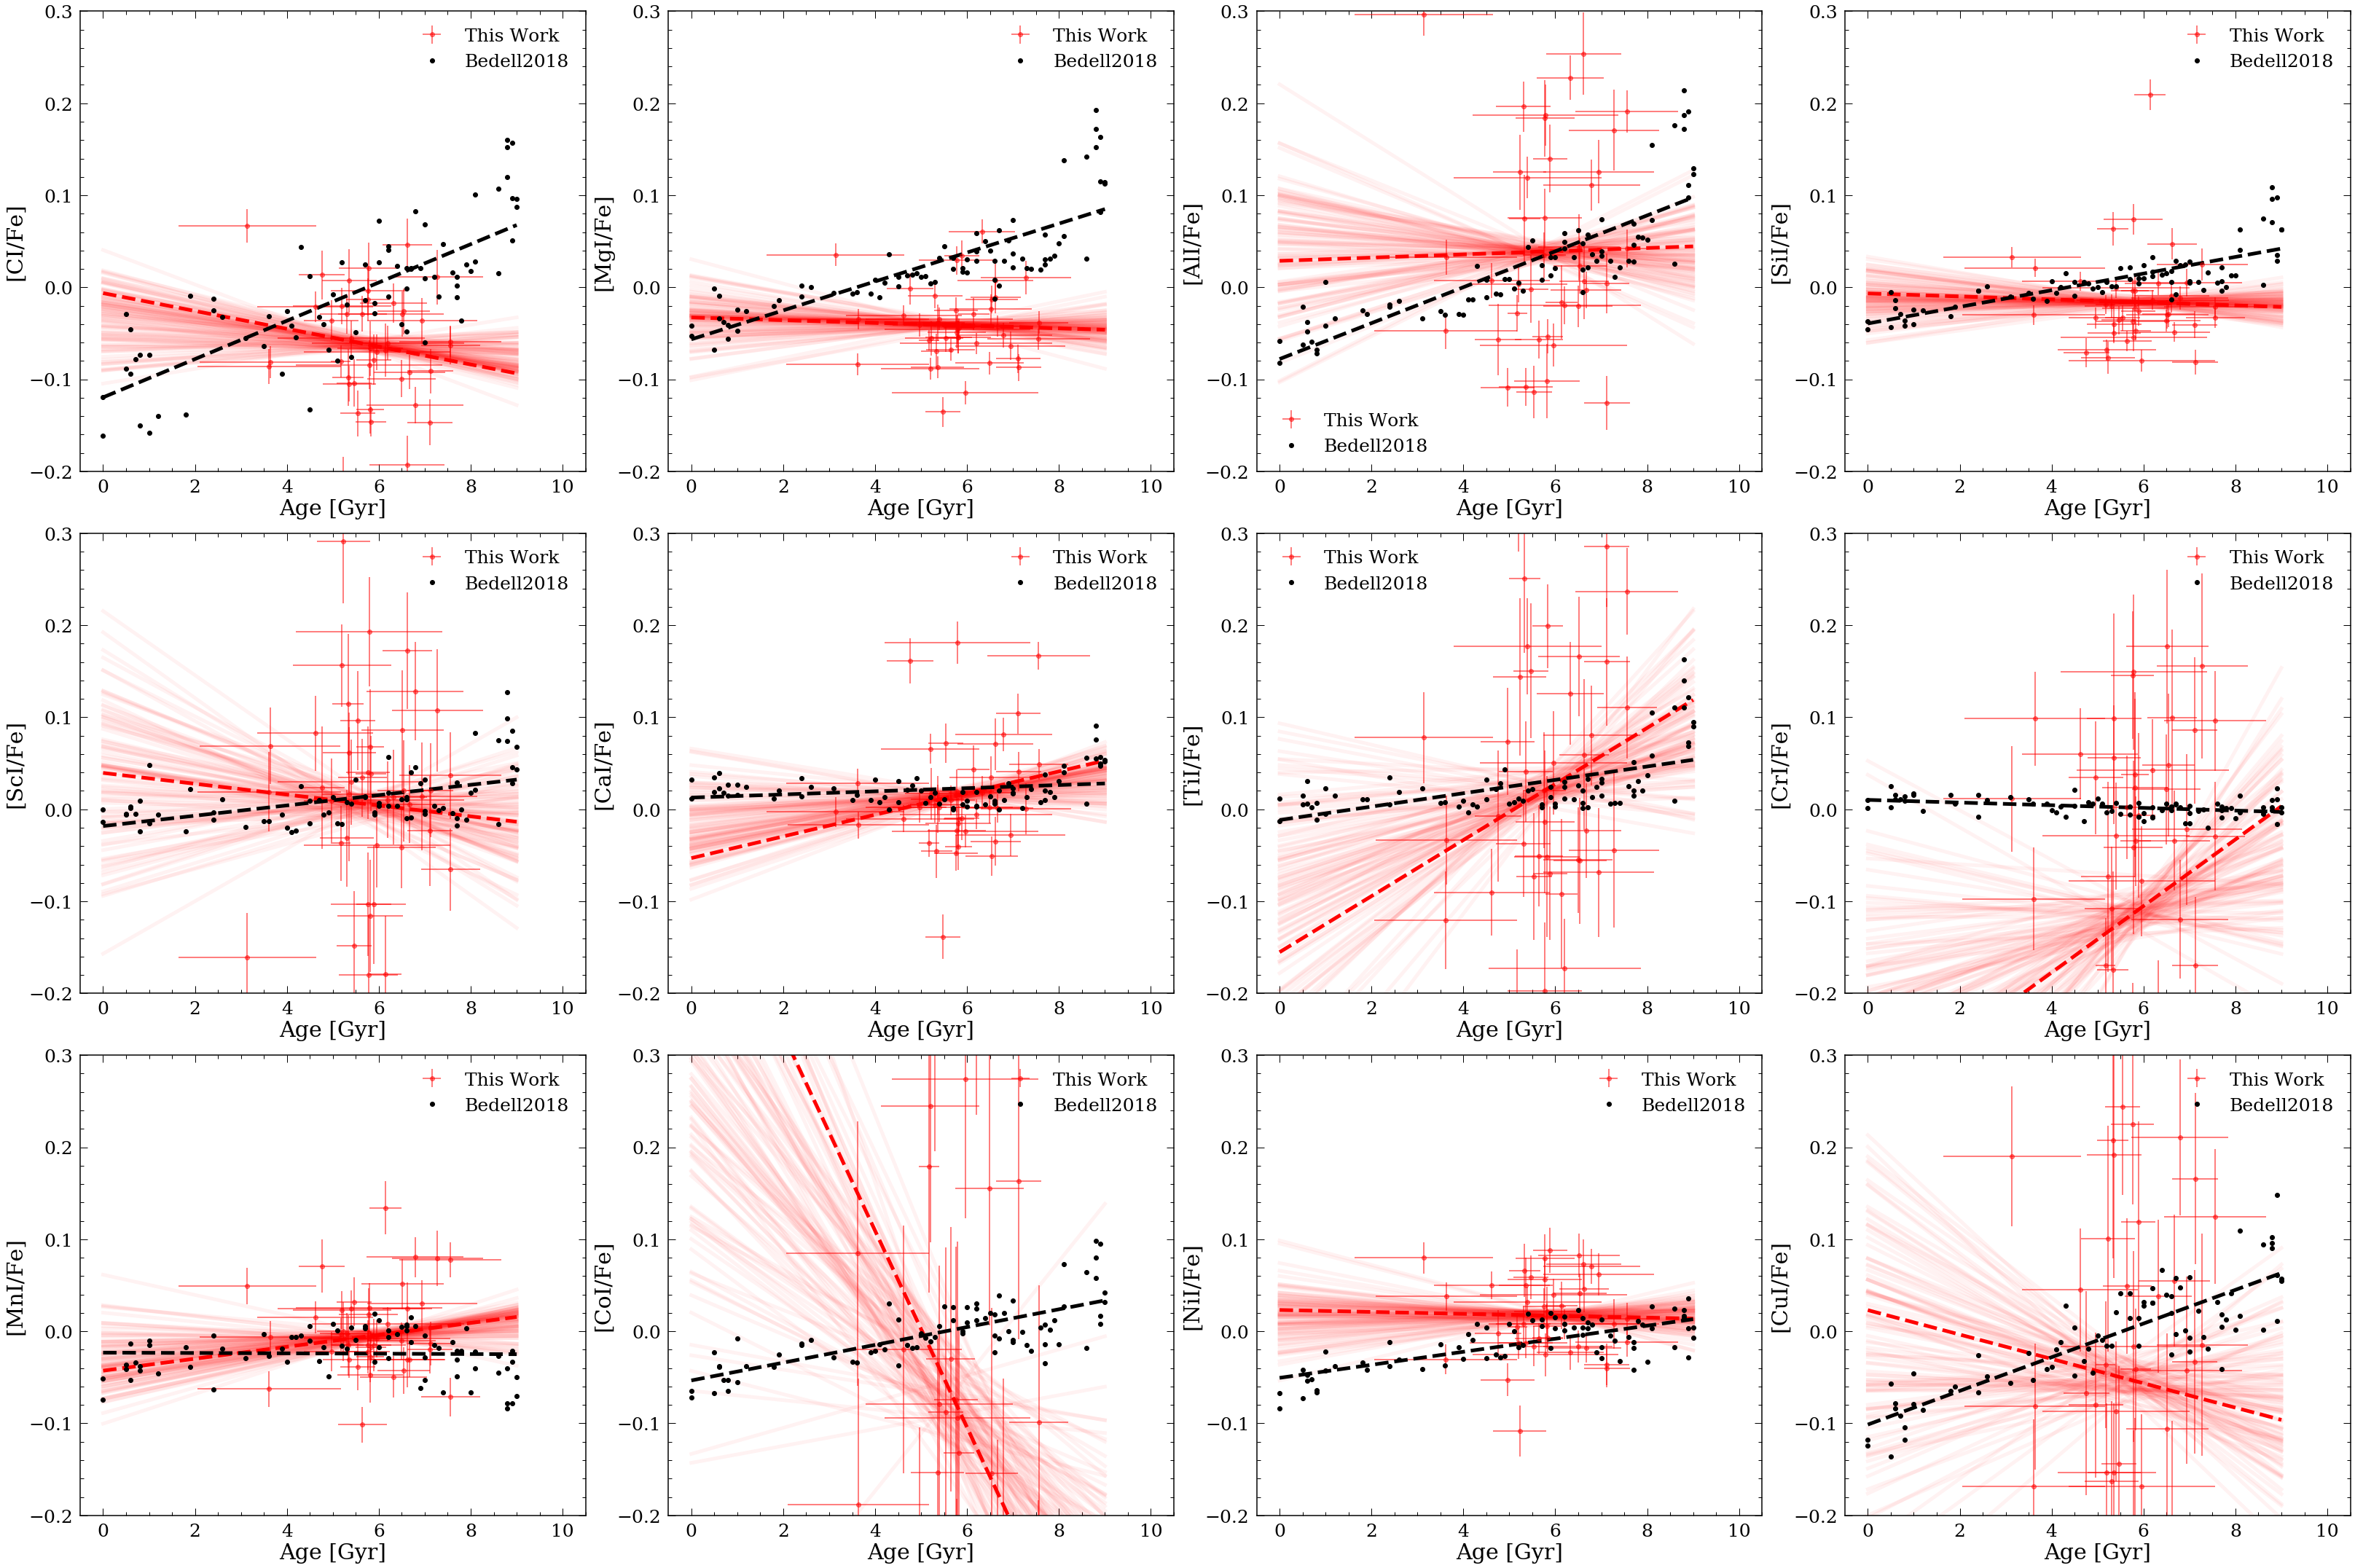

In [132]:
plt.figure(figsize=(45,30))
for i in range(len(abun_apog)):
    update_progress(i/len(abun_apog))
    df_plot=df_st_rvar.loc[df_st_rvar[abun_apog[i]]>-100]
    df_plot=df_plot.reset_index(drop=True)
    df_plot=df_plot.dropna(subset=['kin_age','kin_age_err'])
    plt.subplot(3,4,i+1)
    
    #err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)+np.power(df_plot["age_STD_err"],2.)
    err=np.power(df_plot[abun_apog[i]+"_ERR"],2.)
    
    
    plt.errorbar(df_plot['kin_age'],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],
                 xerr=df_plot["kin_age_err"],fmt='ro',label='This Work',alpha=0.5)
    """
    plt.errorbar(df_plot['age_MAD'],df_plot[abun_apog[i]],yerr=df_plot[abun_apog[i]+"_ERR"],fmt='ro',label='This Work',alpha=0.5)
    """
    
    z = np.polyfit(df_plot['kin_age'],df_plot[abun_apog[i]],1)
    p = np.poly1d(z)
    plt.plot(range(10),p(range(10)),'r--',linewidth=5)
        
    for k in range(100):
        new_age_mock=np.array([np.random.normal(df_plot.iloc[j]['kin_age'],
                        df_plot.iloc[j]['kin_age_err']) for j in range(len(df_plot))])
        new_abun_mock=np.array([np.random.normal(df_plot.iloc[j][abun_apog[i]], 
                        df_plot.iloc[j][abun_apog[i]+"_ERR"]) for j in range(len(df_plot))])
        z = np.polyfit(new_age_mock,new_abun_mock,1)
        p = np.poly1d(z)
        plt.plot(range(10),p(range(10)),'r-',linewidth=5,alpha=0.05)
    
    z = np.polyfit(df_st_md['Agemp'], df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],1)
    p = np.poly1d(z)
    
    plt.errorbar(df_st_md['Agemp'],df_st_md[abund[abun_apog[i]]+'H]']-df_st_md['[Fe/H]'],
                 fmt='ko',label='Bedell2018')
    plt.plot(range(10),p(range(10)),'k--',linewidth=5)
    
    
    plt.ylim([-0.2,0.3])
    plt.xlim([-0.5,10.5])
    plt.ylabel(abund[abun_apog[i]]+'Fe]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
plt.tight_layout()
plt.savefig('Abundances_rvar.png')
    
    